In [1]:
!python -c "import torch; print(torch.__version__)"
!python -c "import torch; print(torch.version.cuda)"

2.4.0+cu121
12.1


In [2]:
# version should match with torch and cuda
%%bash
pip install torch-scatter -f https://data.pyg.org/whl/torch-2.4.0+cu121.html
pip install torch-sparse -f https://data.pyg.org/whl/torch-2.4.0+cu121.html
pip install torch-cluster -f https://data.pyg.org/whl/torch-2.4.0+cu121.html
pip install torch-spline-conv -f https://data.pyg.org/whl/torch-2.4.0+cu121.html

Looking in links: https://data.pyg.org/whl/torch-2.4.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 76.2 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.4.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 14.4 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.4.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 33.1 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.4.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 986.2/986.2 kB 13.3 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data_utils
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import copy

import sys
sys.path.append('/content/drive/MyDrive/Dissertation/DissertationData/DeepAR_File')
from Helper import save_intoCSV
from DeepAR import DeepAR

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
# 1. 讀取和預處理數據
data = pd.read_csv('/content/drive/MyDrive/Dissertation/DissertationData/hobbies.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5650 entries, 0 to 5649
Columns: 1941 entries, d_1 to d_1941
dtypes: int64(1941)
memory usage: 83.7 MB


In [9]:
data['mean_sales'] = data.mean(axis=1)

In [10]:
# 假設 `id` 是商品ID，d_1 到 d_1941 是每天的銷售數據
time_columns = [col for col in data.columns if col.startswith('d_')]

# 將數據轉換為 (樣本數, 時間步長, 特徵數) 的格式
X = data[time_columns].values
X = X.reshape(X.shape[0], -1, 1)  # 這裡特徵數為 1，即每天的銷售數據

# 將目標變量（例如最後一天的銷售量）設為y
y = data['mean_sales'].values  # 假設 'mean_sales' 是你要預測的目標

# 檢查重塑後的數據
print("X shape:", X.shape)  # 應該是 (商品數, 1941, 1)
print("y shape:", y.shape)  # 應該是 (商品數,)

X shape: (5650, 1941, 1)
y shape: (5650,)


In [11]:
# 先將資料分割為訓練+驗證集和測試集 (80/20)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 再將訓練+驗證集分割為訓練集和驗證集 (80/20)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

In [12]:
# 將數據轉換為 PyTorch 的 DataLoader 格式
train_dataset = torch.utils.data.TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                               torch.tensor(y_train, dtype=torch.float32))
val_dataset = torch.utils.data.TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                                             torch.tensor(y_val, dtype=torch.float32))
test_dataset = torch.utils.data.TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                                              torch.tensor(y_test, dtype=torch.float32))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False)

In [14]:
# 模型參數設置
input_size = X_train.shape[2]  # 特徵數
encoder_len = 1  # 使用過去7天的數據來預測
decoder_len = 1  # 預測1天

# 初始化模型
model = DeepAR(input_size=input_size, device=device, encoder_len=encoder_len, decoder_len=decoder_len,
               hidden_size=20, num_layers=3, dropout=0.3)
model.to(device)

DeepAR(
  (encoder): LSTM(1, 20, num_layers=3, batch_first=True, dropout=0.3)
  (decoder): LSTM(1, 20, num_layers=3, batch_first=True, dropout=0.3)
  (squeeze_layers_mu): Linear(in_features=3, out_features=1, bias=True)
  (squeeze_layers_sig): Linear(in_features=3, out_features=1, bias=True)
  (probability_mean): Linear(in_features=20, out_features=1, bias=True)
  (probability_std): Linear(in_features=20, out_features=1, bias=True)
  (std_softplus): Softplus(beta=1.0, threshold=20.0)
)

In [15]:
class RMSSELoss(nn.Module):
    def __init__(self, train_data, epsilon=1e-10):
        """
        初始化 RMSSE 損失函數。

        :param train_data: 用於計算縮放因子的訓練數據 (numpy array 或 tensor)
        :param epsilon: 防止除零的小正數
        """
        super(RMSSELoss, self).__init__()
        self.epsilon = epsilon
        self.train_data = train_data

        # 計算訓練數據的縮放因子
        self.train_diff = torch.diff(train_data, dim=0) ** 2
        self.scale = torch.mean(self.train_diff)

    def forward(self, y_pred, y_true):
        """
        計算 RMSSE 損失。

        :param y_pred: 模型預測值 (tensor)
        :param y_true: 實際值 (tensor)
        :return: RMSSE 值
        """
        n = y_true.size(0)
        squared_errors = (y_pred - y_true) ** 2
        mean_squared_error = torch.mean(squared_errors)

        # 計算 RMSSE
        rmsse = torch.sqrt(mean_squared_error / (self.scale + self.epsilon))
        return rmsse

In [46]:
def calculate_rmsse(y_true, y_pred, train_data, epsilon=1e-10):
    """
    計算 RMSSE 的函數。

    參數:
    - y_true: 真實值 (numpy array)
    - y_pred: 預測值 (numpy array)
    - train_data: 訓練數據集的真實值 (numpy array)
    - epsilon: 防止除零的小正數

    返回:
    - rmsse: 計算出的 RMSSE 值
    """
    # 計算測試集的均方誤差
    squared_errors = np.square(y_true - y_pred)
    mean_squared_error = np.mean(squared_errors)

    # 計算訓練數據集的差分均方誤差
    diff = np.diff(train_data) ** 2
    scale = np.mean(diff)

    # 防止分母為零
    if scale == 0:
        scale = epsilon

    # 計算 RMSSE
    rmsse = np.sqrt(mean_squared_error / scale)
    return rmsse

In [16]:
train_data_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)


Training with learning rate: 0.001

Epoch 1/100, Training Loss: 0.5319, Validation Loss: 0.5984, RMSSE: 0.8350
Epoch 2/100, Training Loss: 0.5072, Validation Loss: 0.5902, RMSSE: 0.8402
Epoch 3/100, Training Loss: 0.4979, Validation Loss: 0.5788, RMSSE: 0.8474
Epoch 4/100, Training Loss: 0.4815, Validation Loss: 0.5687, RMSSE: 0.8822
Epoch 5/100, Training Loss: 0.4843, Validation Loss: 0.5618, RMSSE: 0.8820
Epoch 6/100, Training Loss: 0.4913, Validation Loss: 0.5679, RMSSE: 0.8964
Epoch 7/100, Training Loss: 0.4734, Validation Loss: 0.5610, RMSSE: 0.9022
Epoch 8/100, Training Loss: 0.4796, Validation Loss: 0.5585, RMSSE: 0.9055
Epoch 9/100, Training Loss: 0.4782, Validation Loss: 0.5609, RMSSE: 0.9081
Epoch 10/100, Training Loss: 0.4672, Validation Loss: 0.5581, RMSSE: 0.9309
Epoch 11/100, Training Loss: 0.4799, Validation Loss: 0.5584, RMSSE: 0.9095
Epoch 12/100, Training Loss: 0.4870, Validation Loss: 0.5579, RMSSE: 0.9229
Epoch 13/100, Training Loss: 0.4677, Validation Loss: 0.5606

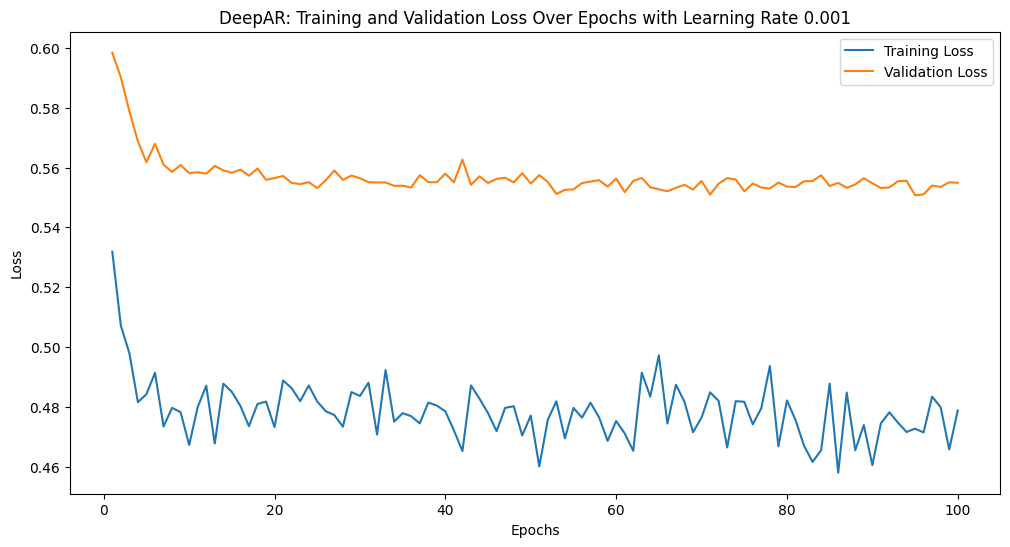

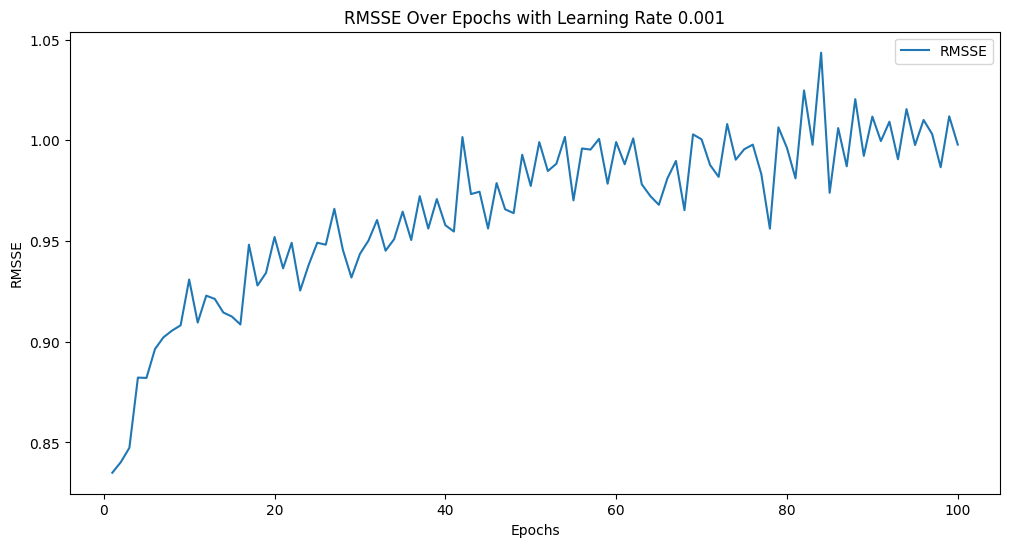


Training with learning rate: 0.0001

Epoch 1/100, Training Loss: 0.5763, Validation Loss: 0.6222, RMSSE: 0.8360
Epoch 2/100, Training Loss: 0.5259, Validation Loss: 0.6184, RMSSE: 0.8320
Epoch 3/100, Training Loss: 0.5342, Validation Loss: 0.6154, RMSSE: 0.8289
Epoch 4/100, Training Loss: 0.5296, Validation Loss: 0.6112, RMSSE: 0.8298
Epoch 5/100, Training Loss: 0.5223, Validation Loss: 0.6052, RMSSE: 0.8276
Epoch 6/100, Training Loss: 0.5242, Validation Loss: 0.6025, RMSSE: 0.8306
Epoch 7/100, Training Loss: 0.5120, Validation Loss: 0.6013, RMSSE: 0.8339
Epoch 8/100, Training Loss: 0.5061, Validation Loss: 0.6002, RMSSE: 0.8350
Epoch 9/100, Training Loss: 0.5123, Validation Loss: 0.5991, RMSSE: 0.8353
Epoch 10/100, Training Loss: 0.5096, Validation Loss: 0.5971, RMSSE: 0.8336
Epoch 11/100, Training Loss: 0.5004, Validation Loss: 0.5963, RMSSE: 0.8347
Epoch 12/100, Training Loss: 0.5035, Validation Loss: 0.5960, RMSSE: 0.8360
Epoch 13/100, Training Loss: 0.5119, Validation Loss: 0.594

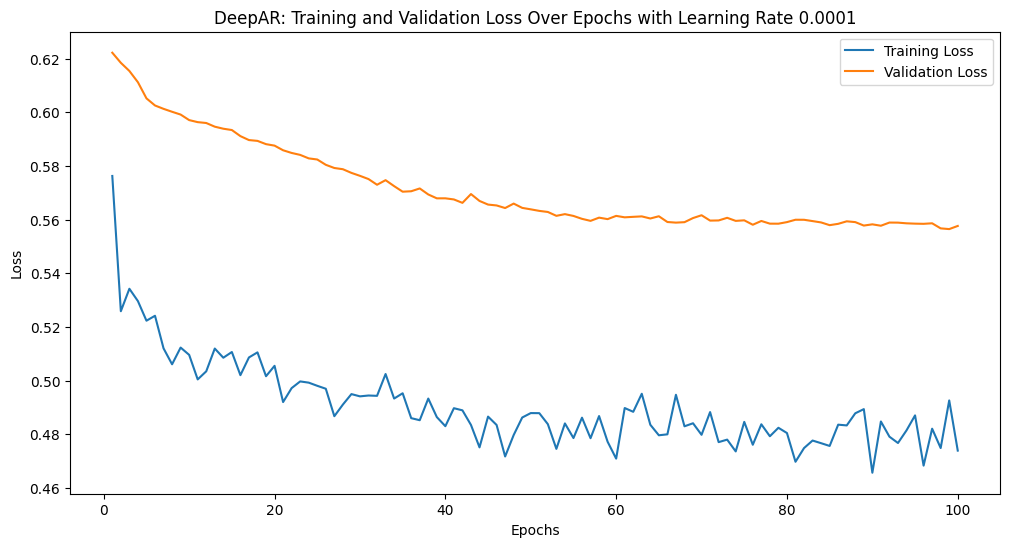

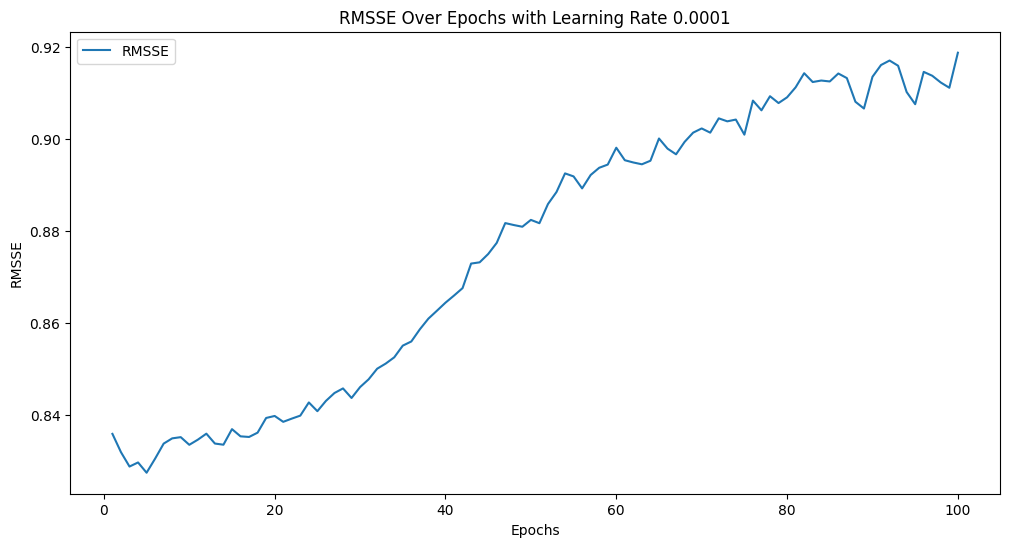


Training with learning rate: 1e-05

Epoch 1/100, Training Loss: 0.5841, Validation Loss: 0.6624, RMSSE: 0.8779
Epoch 2/100, Training Loss: 0.5615, Validation Loss: 0.6496, RMSSE: 0.8679
Epoch 3/100, Training Loss: 0.5601, Validation Loss: 0.6401, RMSSE: 0.8596
Epoch 4/100, Training Loss: 0.5437, Validation Loss: 0.6332, RMSSE: 0.8530
Epoch 5/100, Training Loss: 0.5450, Validation Loss: 0.6280, RMSSE: 0.8474
Epoch 6/100, Training Loss: 0.5412, Validation Loss: 0.6245, RMSSE: 0.8431
Epoch 7/100, Training Loss: 0.5353, Validation Loss: 0.6221, RMSSE: 0.8396
Epoch 8/100, Training Loss: 0.5338, Validation Loss: 0.6205, RMSSE: 0.8372
Epoch 9/100, Training Loss: 0.5364, Validation Loss: 0.6194, RMSSE: 0.8354
Epoch 10/100, Training Loss: 0.5340, Validation Loss: 0.6186, RMSSE: 0.8341
Epoch 11/100, Training Loss: 0.5333, Validation Loss: 0.6181, RMSSE: 0.8331
Epoch 12/100, Training Loss: 0.5298, Validation Loss: 0.6175, RMSSE: 0.8324
Epoch 13/100, Training Loss: 0.5358, Validation Loss: 0.6170

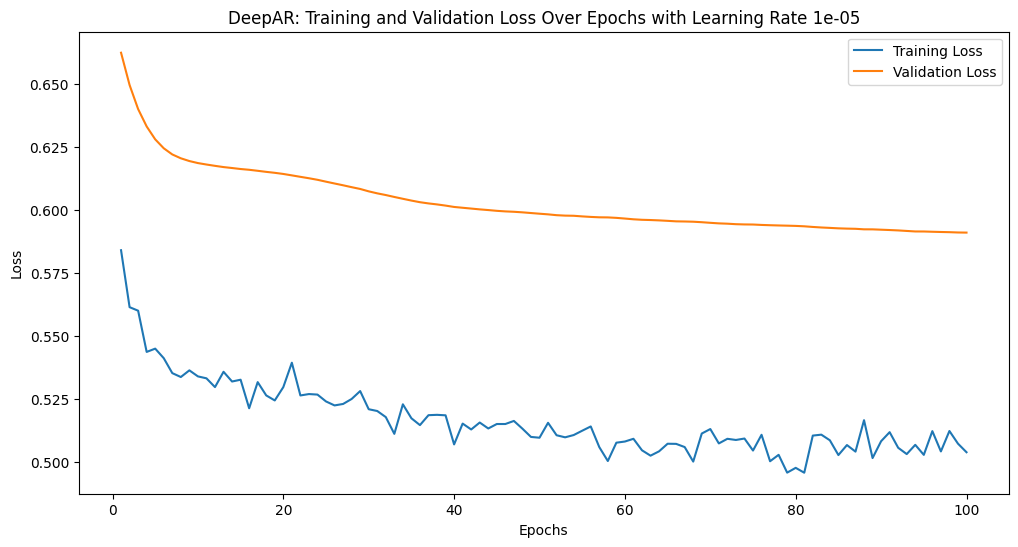

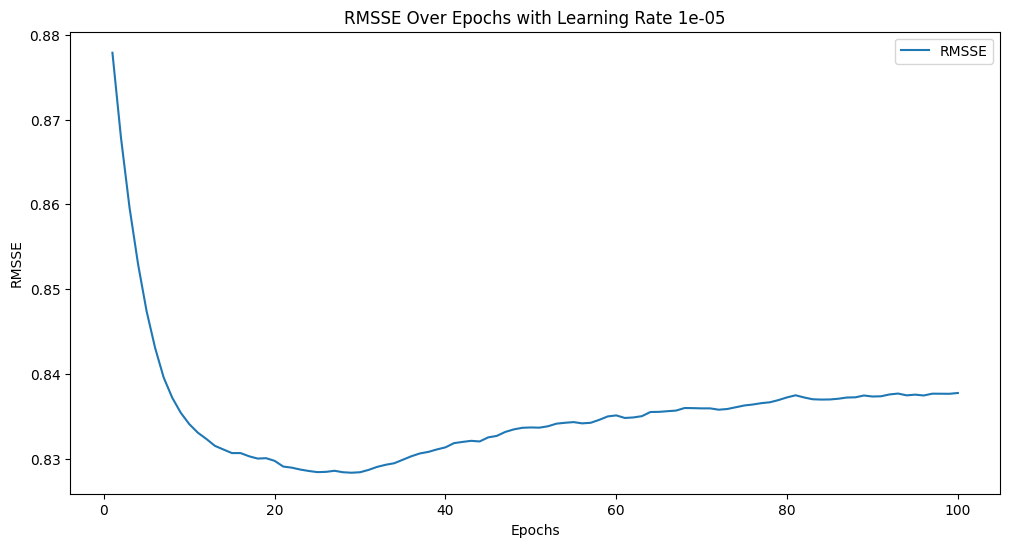

In [22]:
# 設定學習率列表
learning_rates = [1e-03, 1e-04, 1e-05]
best_val_loss = float('inf')
best_model_state = None
best_lr = None

# Loop over each learning rate
for lr in learning_rates:
    print(f"\nTraining with learning rate: {lr}\n")

    # Initialize model and optimizer for each learning rate
    model = DeepAR(input_size=input_size, device=device, encoder_len=encoder_len, decoder_len=decoder_len,
                   hidden_size=20, num_layers=3, dropout=0.3).to(device)

    criterion = RMSSELoss(train_data_tensor)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    epochs = 100
    train_losses = []
    val_losses = []
    rmsse_scores = []

    best_val_loss = float('inf')
    best_model_state = None

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            if len(y_batch.shape) == 1:
                y_batch = y_batch.unsqueeze(1)
            if len(y_batch.shape) == 2:
                y_batch = y_batch.unsqueeze(2)

            optimizer.zero_grad()
            outputs, mu, sigma, _, _ = model(X_batch, y_batch)
            loss = criterion(mu, y_batch)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        train_losses.append(running_loss / len(train_loader))

        # Validation
        model.eval()
        val_running_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)

                if len(y_batch.shape) == 1:
                    y_batch = y_batch.unsqueeze(1)
                if len(y_batch.shape) == 2:
                    y_batch = y_batch.unsqueeze(2)

                outputs, mu, sigma, _, _ = model(X_batch, y_batch)
                val_loss = criterion(mu, y_batch)
                val_running_loss += val_loss.item()

        val_loss_avg = val_running_loss / len(val_loader)
        val_losses.append(val_loss_avg)

        # Save the best model for the current learning rate
        if val_loss_avg < best_val_loss:
            best_val_loss = val_loss_avg
            best_model_state = copy.deepcopy(model.state_dict())

        # Calculate RMSSE
        y_val_pred = []
        with torch.no_grad():
            for X_batch, _ in val_loader:
                X_batch = X_batch.to(device)
                outputs, mu, sigma, _, _ = model(X_batch, X_batch[:, -1:, :])
                y_val_pred.append(mu.cpu().numpy())
        y_val_pred = np.concatenate(y_val_pred, axis=0)

        rmsse_score = calculate_rmsse(y_val, y_val_pred, y_train)
        rmsse_scores.append(rmsse_score)

        print(f'Epoch {epoch + 1}/{epochs}, Training Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}, RMSSE: {rmsse_score:.4f}')

    # Save the best model for this learning rate
    model_save_path = f"/content/drive/MyDrive/Dissertation/DissertationData/BestModel0826/deep_ar_bm0826_lr_{lr}.pth"
    torch.save(best_model_state, model_save_path)
    print(f"Best model for learning rate {lr} saved to {model_save_path} with validation loss {best_val_loss:.4f}")

    # 繪製損失曲線
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'DeepAR: Training and Validation Loss Over Epochs with Learning Rate {lr}')
    plt.legend()
    plt.show()

    # 繪製 RMSSE 曲線
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, epochs + 1), rmsse_scores, label='RMSSE')
    plt.xlabel('Epochs')
    plt.ylabel('RMSSE')
    plt.title(f'RMSSE Over Epochs with Learning Rate {lr}')
    plt.legend()
    plt.show()

In [24]:
#import lr-0.00001
model_save_path = '/content/drive/MyDrive/Dissertation/DissertationData/BestModel0826/deep_ar_bm0826_lr_1e-05.pth'

model = DeepAR(input_size=input_size, device=device, encoder_len=encoder_len, decoder_len=decoder_len,
               hidden_size=20, num_layers=3, dropout=0.3)
model.load_state_dict(torch.load(model_save_path))
model.to(device)

<ipython-input-24-70481ebd615c>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path))


DeepAR(
  (encoder): LSTM(1, 20, num_layers=3, batch_first=True, dropout=0.3)
  (decoder): LSTM(1, 20, num_layers=3, batch_first=True, dropout=0.3)
  (squeeze_layers_mu): Linear(in_features=3, out_features=1, bias=True)
  (squeeze_layers_sig): Linear(in_features=3, out_features=1, bias=True)
  (probability_mean): Linear(in_features=20, out_features=1, bias=True)
  (probability_std): Linear(in_features=20, out_features=1, bias=True)
  (std_softplus): Softplus(beta=1.0, threshold=20.0)
)

In [25]:
# 設定模型為評估模式
model.eval()

# 儲存預測值和真實值
y_test_pred = []
y_test_true = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        # 模型預測
        outputs, mu, sigma, _, _ = model(X_batch, X_batch[:, -1:, :])

        # 儲存預測值和真實值
        y_test_pred.append(mu.cpu().numpy())
        y_test_true.append(y_batch.cpu().numpy())

# 將結果拼接為numpy陣列
y_test_pred = np.concatenate(y_test_pred, axis=0)
y_test_true = np.concatenate(y_test_true, axis=0)

In [36]:
def calculate_rmse(y_true, y_pred):
    """
    計算 RMSE 的函數。

    參數:
    - y_true: 真實值 (numpy array)
    - y_pred: 預測值 (numpy array)

    返回:
    - rmse: 計算出的 RMSE 值
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    mse = np.mean((y_true - y_pred) ** 2)
    rmse = np.sqrt(mse)
    return rmse

In [48]:
def calculate_wrmsse(y_true, y_pred, y_train, weights=None, epsilon=1e-10):
    """
    计算 WRMSSE 的函数。

    参数:
    - y_true: 真实值 (numpy array)
    - y_pred: 预测值 (numpy array)
    - y_train: 训练集的真实值 (numpy array)
    - weights: 每个时间序列的权重 (numpy array)，默认 None
    - epsilon: 防止除零的小正数

    返回:
    - wrmsse: 计算出的 WRMSSE 值
    """
    # 确保输入是 numpy 数组
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    y_train = np.asarray(y_train)

    # 计算每个时间序列的均方误差（MSE）
    mse = np.mean((y_true - y_pred) ** 2, axis=0)

    # 计算差分的均方差（用于 RMSSE 计算的分母）
    diff = np.diff(y_train, axis=0) ** 2
    denominator = np.mean(diff, axis=0)

    # 避免分母为零：将分母为零的地方设置为一个小正数
    denominator = np.where(denominator > epsilon, denominator, epsilon)

    # 计算每个时间序列的 RMSSE
    rmsse = np.sqrt(mse / denominator)

    # 计算加权 RMSSE
    if weights is not None:
        weights = np.asarray(weights)
        if weights.shape[0] != rmsse.shape[0]:
            raise ValueError("Weights length must match the number of series.")
        wrmsse = np.sum(weights * rmsse) / np.sum(weights)
    else:
        wrmsse = np.mean(rmsse)

    return wrmsse

In [55]:
# 計算 RMSE
rmse = calculate_rmse(y_test_true, y_test_pred)
print(f'Test RMSE: {rmse:.4f}')

rmsse = calculate_rmsse(y_test_true, y_test_pred, y_train)
print(f'Test RMSSE: {rmsse:.4f}')

y_train_np = y_train if isinstance(y_train, np.ndarray) else y_train.numpy()
if y_train_np.ndim == 1:
    y_train_np = np.expand_dims(y_train_np, axis=1)

wrmsse = calculate_wrmsse(y_test_true, y_test_pred, y_train)
print(f'Test WRMSSE: {wrmsse:.4f}')

Test RMSE: 1.0162
Test RMSSE: 0.7062
Test WRMSSE: 0.3675


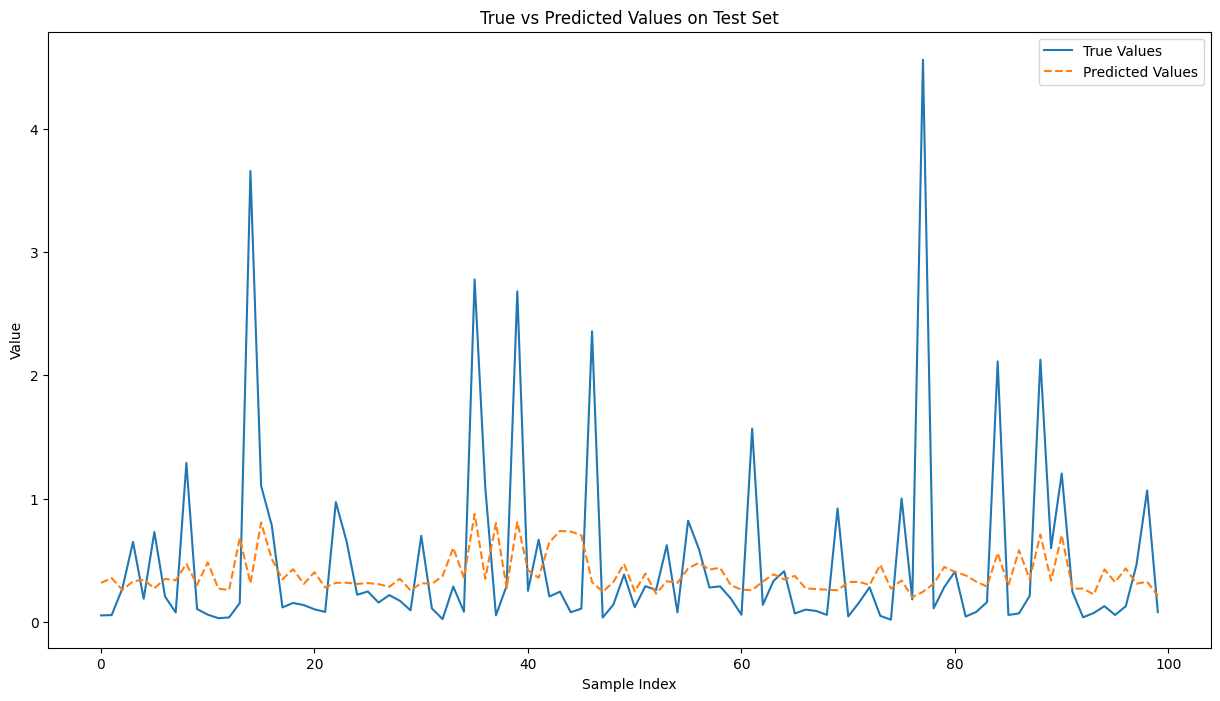

In [56]:
# 選擇一些樣本進行可視化比較
n_samples_to_plot = 100  # 選擇需要展示的樣本數

# 壓縮 y_test_pred，使其形狀與 y_test_true 一致
y_test_pred_squeezed = y_test_pred.squeeze()

plt.figure(figsize=(15, 8))
plt.plot(y_test_true[:n_samples_to_plot], label='True Values')
plt.plot(y_test_pred_squeezed[:n_samples_to_plot], label='Predicted Values', linestyle='dashed')
plt.title('True vs Predicted Values on Test Set')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.show()